# Looked After Children (LAC) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify
from scipy import stats
import contextily as ctx
import libpysal
from pysal.explore import esda
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen, Rook
from splot.esda import plot_local_autocorrelation, lisa_cluster
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('tableau-colorblind10')
color='#702A7D'

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH LatestAssessment AS (
  SELECT
    a.person_id,
    a.StartDate,
    ROW_NUMBER() OVER (PARTITION BY a.person_id ORDER BY a.StartDate DESC) AS rn,
    f.category
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_bmbc_Childrens_Social_Services_Assessments` AS a
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_FactorLookup` AS f
    ON a.factorid = f.factorid
),
CIC_WithAddress AS (
  SELECT
    cic.person_id,
    cic.StartDate,
    cic.EndDate,
    cic.EthnicOrigin,
    p.birth_datetime AS DateOfBirth,
    la.category,
    a.partialPostcode AS PCArea,
    a.SOA AS LSOA,
    /* For each CiC row, rank the joined address rows 
       (if any) by DateEventRecorded (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY cic.person_id, cic.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiC` cic
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON cic.person_id = a.person_id
      AND DATE(a.DateEvent) <= cic.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON cic.person_id = p.person_id
  LEFT JOIN
    LatestAssessment la
      ON cic.person_id = la.person_id
      AND la.rn = 1
)
SELECT 
  person_id,
  PCArea,       
  StartDate,
  EndDate,
  EthnicOrigin,
  DateOfBirth,
  LSOA,         
  category AS Category
FROM
  CIC_WithAddress
WHERE 
  rn = 1;
"""

# Load Query into Pandas Dataframe

In [4]:
cic = pandas_gbq.read_gbq(query)

Downloading: 100%|██████████|


In [5]:
# Information about the columns
cic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1917 non-null   object             
 1   PCArea        1759 non-null   object             
 2   StartDate     1917 non-null   dbdate             
 3   EndDate       961 non-null    dbdate             
 4   EthnicOrigin  1917 non-null   object             
 5   DateOfBirth   1911 non-null   datetime64[us, UTC]
 6   LSOA          1333 non-null   object             
 7   Category      1067 non-null   object             
dtypes: datetime64[us, UTC](1), dbdate(2), object(5)
memory usage: 119.9+ KB


In [6]:
# Count number of missing values
missing_values = cic.isnull().sum()
total_values = cic.shape[0]
percentage_missing = round(missing_values/total_values*100, 2)
percentage_missing

person_id        0.00
PCArea           8.24
StartDate        0.00
EndDate         49.87
EthnicOrigin     0.00
DateOfBirth      0.31
LSOA            30.46
Category        44.34
dtype: float64

In [7]:
# Strip whitespace from all string/object columns
cic = cic.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [8]:
cic.Category.nunique()

23

# Load Bradford Children Population Data 0-17 years, 2021.
source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates

In [9]:
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)
population_data.columns

Index(['LAD 2021 Code', 'LAD 2021 Name', 'LSOA 2021 Code', 'LSOA 2021 Name',
       'TotalPop', 'FemalePop', 'MalePop'],
      dtype='object')

# Load Bradford Boundary Data
source: https://borders.ukdataservice.ac.uk/

In [10]:
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradord_boundary_data = gpd.read_file(boundary_data_filepath)

# Print data type and crs
print(type(bradord_boundary_data))
print(bradord_boundary_data.crs)
print(bradord_boundary_data.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:27700
Index(['lsoa21cd', 'lsoa21nm', 'label', 'name', 'geometry'], dtype='object')


# Load Index of Multiple Deprivation (IMD) Data
source: https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd

In [11]:
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd = gpd.read_file(imd_filepath)

In [12]:
# Display the columns in the IMD data
imd.columns

Index(['lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths',
       'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore',
       'IMDRank0', 'IMDDec0', 'IncScore', 'IncRank', 'IncDec', 'EmpScore',
       'EmpRank', 'EmpDec', 'EduScore', 'EduRank', 'EduDec', 'HDDScore',
       'HDDRank', 'HDDDec', 'CriScore', 'CriRank', 'CriDec', 'BHSScore',
       'BHSRank', 'BHSDec', 'EnvScore', 'EnvRank', 'EnvDec', 'IDCScore',
       'IDCRank', 'IDCDec', 'IDOScore', 'IDORank', 'IDODec', 'CYPScore',
       'CYPRank', 'CYPDec', 'ASScore', 'ASRank', 'ASDec', 'GBScore', 'GBRank',
       'GBDec', 'WBScore', 'WBRank', 'WBDec', 'IndScore', 'IndRank', 'IndDec',
       'OutScore', 'OutRank', 'OutDec', 'TotPop', 'DepChi', 'Pop16_59',
       'Pop60+', 'WorkPop', 'geometry'],
      dtype='object')

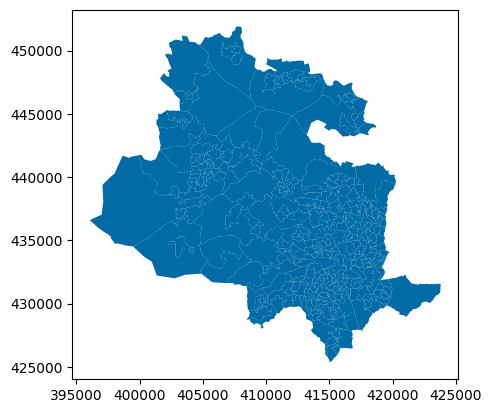

In [13]:
# Display the map

bradord_boundary_data.plot();

In [14]:
# Drop rows where LSOA is missing
cic = cic.dropna(subset=['LSOA'])
cic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 1 to 1915
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1333 non-null   object             
 1   PCArea        1332 non-null   object             
 2   StartDate     1333 non-null   dbdate             
 3   EndDate       658 non-null    dbdate             
 4   EthnicOrigin  1333 non-null   object             
 5   DateOfBirth   1333 non-null   datetime64[us, UTC]
 6   LSOA          1333 non-null   object             
 7   Category      749 non-null    object             
dtypes: datetime64[us, UTC](1), dbdate(2), object(5)
memory usage: 93.7+ KB


In [15]:
# Example of unique LSOA prefixes
cic['lsoa_prefix'] = cic['LSOA'].str[:3]
print(cic['lsoa_prefix'].unique())

['E01' '' 'S01' 'W01']


In [16]:
# Filter cic to keep only English LSOAs (starting with 'E01') and remove empty strings
cic_english_lsoa = cic[cic['LSOA'].str.startswith('E01', na=False)].copy()

print(f"Number of rows in cic before filtering: {len(cic)}")
print(f"Number of rows in cic_english_lsoa after filtering: {len(cic_english_lsoa)}")

Number of rows in cic before filtering: 1333
Number of rows in cic_english_lsoa after filtering: 1160


# Merge intervention and boundary data

In [17]:
# 1. Check for missing matches before merging
print("Bradford boundary unique LSOAs:", len(bradord_boundary_data['lsoa21cd'].unique()))
print("CIC English unique LSOAs:", len(cic_english_lsoa['LSOA'].unique()))
print("Common LSOAs:", len(set(bradord_boundary_data['lsoa21cd']).intersection(set(cic_english_lsoa['LSOA']))))

# 2. Use left merge to preserve geometry
merged_data = bradord_boundary_data.merge(
    cic_english_lsoa,
    left_on='lsoa21cd',
    right_on='LSOA',
    how='left',
)

# 3. Verify geometry column is preserved
print("Geometry column present:", 'geometry' in merged_data.columns)
print(merged_data.crs)

Bradford boundary unique LSOAs: 312
CIC English unique LSOAs: 398
Common LSOAs: 227
Geometry column present: True
EPSG:27700


<Axes: >

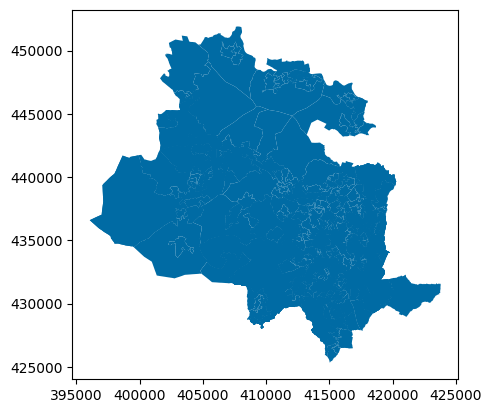

In [18]:
# Confirm the map plot
merged_data.plot()

In [19]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   lsoa21cd      992 non-null    object             
 1   lsoa21nm      992 non-null    object             
 2   label         992 non-null    object             
 3   name          992 non-null    object             
 4   geometry      992 non-null    geometry           
 5   person_id     907 non-null    object             
 6   PCArea        907 non-null    object             
 7   StartDate     907 non-null    dbdate             
 8   EndDate       474 non-null    dbdate             
 9   EthnicOrigin  907 non-null    object             
 10  DateOfBirth   907 non-null    datetime64[us, UTC]
 11  LSOA          907 non-null    object             
 12  Category      491 non-null    object             
 13  lsoa_prefix   907 non-null    object             
dtypes:

In [20]:
# Drop unwanted columns
columns_to_drop = ['lsoa21nm', 'label', 'LSOA']
merged_data.drop(columns=columns_to_drop, inplace=True)

In [21]:
# Convert dates data types and ensure they are timezone-aware in UTC
dates_columns = ['StartDate', 'EndDate', 'DateOfBirth']
merged_data[dates_columns] = merged_data[dates_columns].apply(pd.to_datetime)

# Convert to timezone-aware datetime objects in UTC
merged_data['StartDate'] = merged_data['StartDate'].dt.tz_localize('UTC')
merged_data['EndDate'] = merged_data['EndDate'].dt.tz_localize('UTC')
merged_data['DateOfBirth'] = merged_data['DateOfBirth'].astype('datetime64[ns, UTC]')

In [22]:
merged_data.dtypes

lsoa21cd                     object
name                         object
geometry                   geometry
person_id                    object
PCArea                       object
StartDate       datetime64[ns, UTC]
EndDate         datetime64[ns, UTC]
EthnicOrigin                 object
DateOfBirth     datetime64[ns, UTC]
Category                     object
lsoa_prefix                  object
dtype: object

In [23]:
# Creating New Columns

# Number of Days in Intervention
merged_data['num_of_days_in_intervention'] = (merged_data['EndDate'] - merged_data['StartDate']).dt.days

# Age at Entry
seconds_in_year = 365.25 * 24 * 3600

age_series = ((merged_data['StartDate'] - merged_data['DateOfBirth'])
              .dt.total_seconds() / seconds_in_year).round()

# Convert to numeric explicitly, then cast to Pandas nullable int type ('Int64')
merged_data['age_at_entry'] = pd.to_numeric(age_series, errors='coerce').astype('Int64')

# Age Binning
bins = [0, 1, 4, 9, 15, 16]
labels = ['Under 1', '1-4', '5-9', '10-15', '16+']
merged_data['entry_agegroup'] = pd.cut(merged_data['age_at_entry'], 
                             bins=bins, 
                             labels=labels,
                             right=True)

#### Number of LAC per LSOA - Is there a significant variation in number of LAC across LSOAs

In [24]:
# Group by LSOA and count the number of children
children_per_lsoa = merged_data.groupby('lsoa21cd', as_index=False).agg(
    children_count=('lsoa21cd', 'size'),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

# Merge with IMD Data
columns_to_include_from_imd = [
    'lsoa11cd', 'IMD_Decile', 'IMDScore',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec',
    'HDDDec', 'DepChi'
]

children_per_lsoa = children_per_lsoa.merge(
    imd[columns_to_include_from_imd],
    left_on ='lsoa21cd',
    right_on='lsoa11cd',
    how='left'
).drop(columns='lsoa11cd')

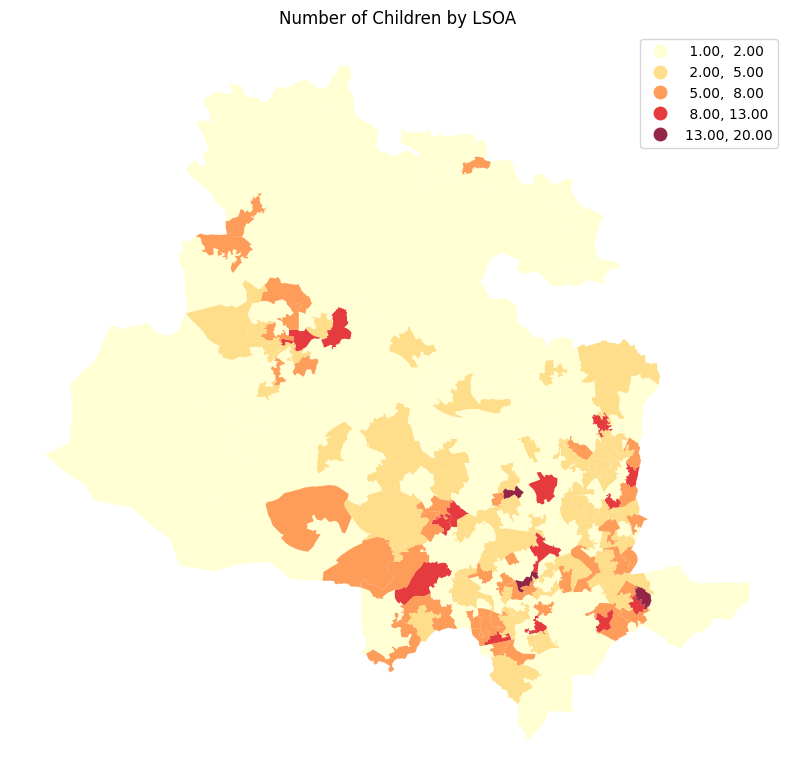

In [25]:
# Step 3: Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 

children_per_lsoa.plot(
    ax=ax,                  
    column='children_count',
    scheme='FisherJenks',     
    cmap='YlOrRd',
    alpha=0.85,
    legend=True,            
)

# Remove axis for better visualization
ax.set_axis_off()

# Add a title
ax.set_title("Number of Children by LSOA")

# Show the plot
plt.show()

### LAC Population Rate  by LSOA - Looking at rate helps us balance uneven population across LSOAs

In [26]:
# Merge with population data
children_population = children_per_lsoa.merge(
    population_data[['LSOA 2021 Code', 'TotalPop']],
    left_on='lsoa21cd',
    right_on='LSOA 2021 Code',
    how='left'
).drop(columns='LSOA 2021 Code')

# Calculate children proportion
children_population['children_per_total_pop'] = (
    children_population['children_count'] /
    children_population['TotalPop']) * 100

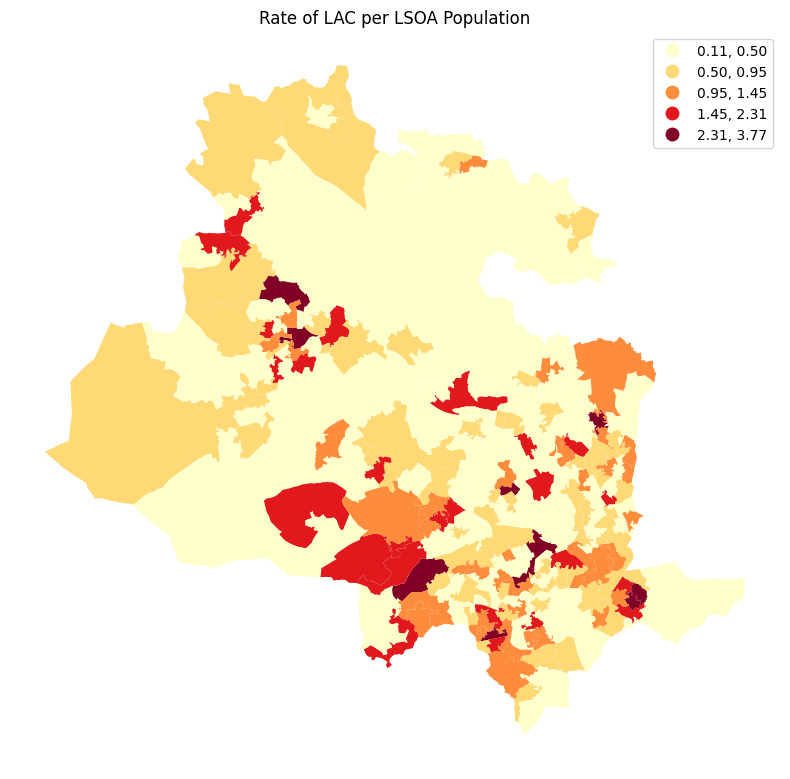

In [27]:
# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# Set CRS explicitly
# children_population = children_population.set_crs(epsg=27700)

#  Convert to we mercator for basemap
# children_population = children_population.to_crs(epsg=3857)

# Plot the LAC rate
children_population.plot(
    ax=ax,
    column='children_per_total_pop',
    scheme='NaturalBreaks',
    cmap='YlOrRd',
    legend=True
)
ax.set_axis_off()
ax.set_title('Rate of LAC per LSOA Population')

# Add basemap
# ctx.add_basemap(ax, 
#                 source=ctx.providers.CartoDB.Positron,  
#                 zoom=12,
#                 attribution=True)
plt.tight_layout()
plt.savefig("../figs/pop_rate_imd_decile.png", dpi=300)
plt.show()

### Global Spatial Autocorrelation for LAC Population Rate Using Moran I and Getis-Ord G
* Moran's I asks: "Are similar values near each other?"
* Getis-Ord G asks: "Are high values clustering together, or are low values clustering together?"

In [28]:
from libpysal.weights import KNN
w_queen = Queen.from_dataframe(children_population)
w_queen.transform = 'r' 

# Calculate Moran's I
moran_queen = Moran(children_population['children_per_total_pop'], w_queen)
print("Queen: \n")
print(f"Moran's I: {moran_queen.I}")
print(f"p-value: {moran_queen.p_sim}")
print(f"z-score: {moran_queen.z_sim}")

# KNN 
centroids = children_population.geometry.centroid
coords = list(zip(centroids.x, centroids.y))
w_knn = KNN(coords, k=6)
w_knn.transform = 'r'

moran_knn = Moran(children_population['children_per_total_pop'], w_knn)
print("KNN: \n")
print(f"Moran's I: {moran_knn.I}")
print(f"p-value: {moran_knn.p_sim}")
print(f"z-score: {moran_knn.z_sim}")

Queen: 

Moran's I: 0.11414647793575633
p-value: 0.001
z-score: 3.29469209713019
KNN: 

Moran's I: 0.09108311854960001
p-value: 0.003
z-score: 3.0807430258290234


In [29]:
# Calculate Getis-Ord G
# Queen weights matrix
print("Getis-Ord G, Queen Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_queen)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

# KNN
print("\nGetis-Ord G, KNN Weights")
g = esda.getisord.G(children_population['children_per_total_pop'], w_knn)
print(f"Getis-Ord G: {g.G}")
print(f"p-value: {g.p_sim}")
print(f"z-score: {g.z_sim}")

Getis-Ord G, Queen Weights
Getis-Ord G: 0.020106281602411423
p-value: 0.003
z-score: 2.7698358633938454

Getis-Ord G, KNN Weights
Getis-Ord G: 0.020761309047575973
p-value: 0.006
z-score: 2.7554636695277384


___________
Low Moran I's score suggest spatial randomness. No spatial autocorrelation.<br>
Getis-Ord G: The results shows there are hig value clusters (hot spots) with a confidence level of 96.6%

### Local Autocorrelation with Getis-Ord Gi* and Local Indicators of Spatial Association (LISA)

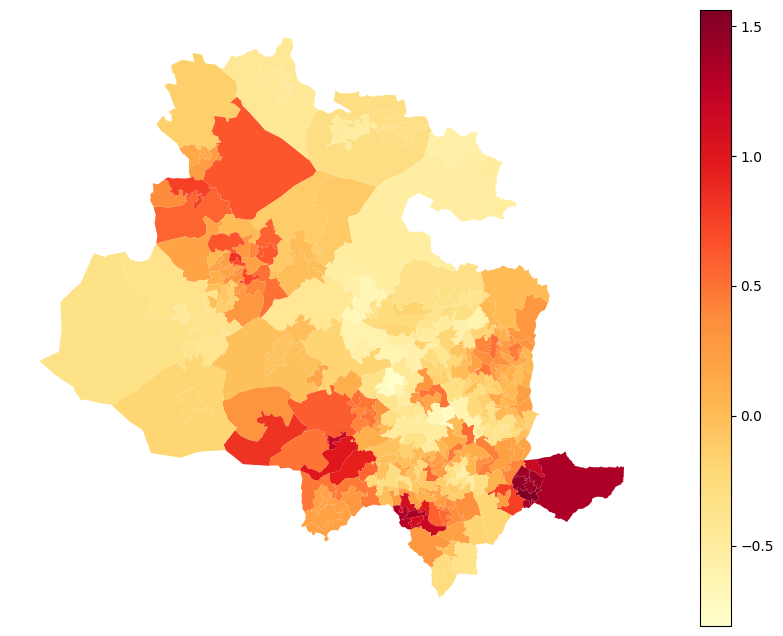

In [30]:
# Hostspot analysis Getis-Ord Gi*
from esda.getisord import G_Local

gi = G_Local(children_population['children_per_total_pop'], w_knn, star=True)
children_population['gi_Zscore'] = gi.Zs
children_population.plot(
    column='gi_Zscore', cmap='YlOrRd',
    legend=True,
    figsize=(12,8)
)
plt.axis('off')
plt.show()

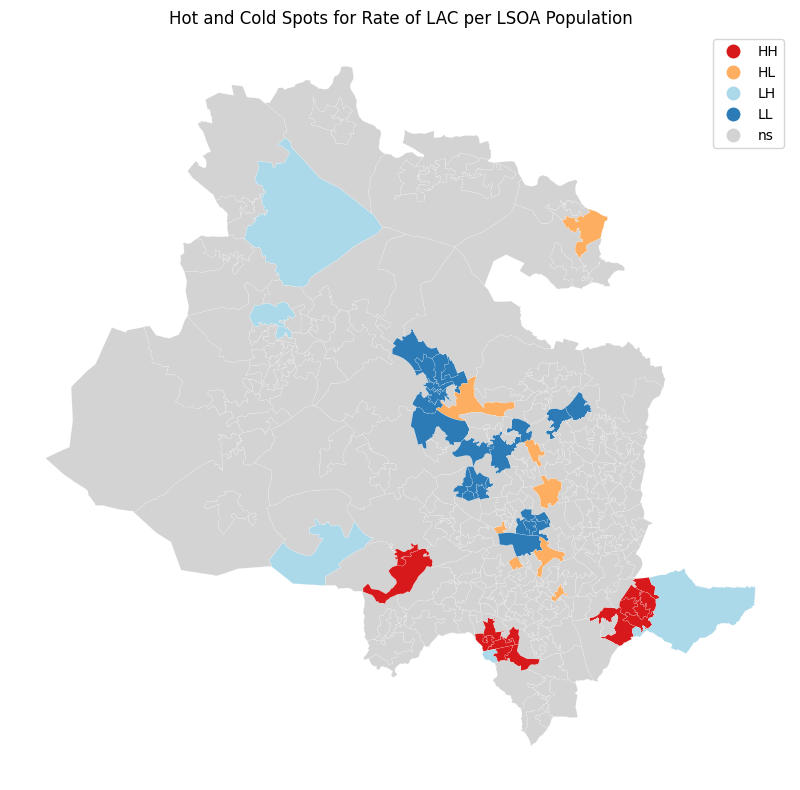

In [31]:
from splot.esda import lisa_cluster

# Set CRS explicitly
# children_population = children_population.set_crs(epsg=27700, allow_override=True)

#  Convert to we mercator for basemap
# children_population = children_population.to_crs(epsg=3857)

# Local Moran I
lisa = Moran_Local(children_population['children_per_total_pop'], w_knn)

# Plot the local autocorrelation; adjust overall figure size as needed
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lisa_cluster(lisa, children_population, p=0.05, ax=ax)
ax.set_title("Hot and Cold Spots for Rate of LAC per LSOA Population")

# Add basemap
# ctx.add_basemap(ax,
#                 crs=children_population.crs.to_string(),
#                 source=ctx.providers.CartoDB.Positron,  
#                 zoom=12,
#                 attribution=True)
plt.tight_layout()
plt.savefig("../figs/lac_hot-cold spots.png", dpi=300)
plt.show()

##### What percentage of LSOAs accounts for what percentage of Children in LAC?

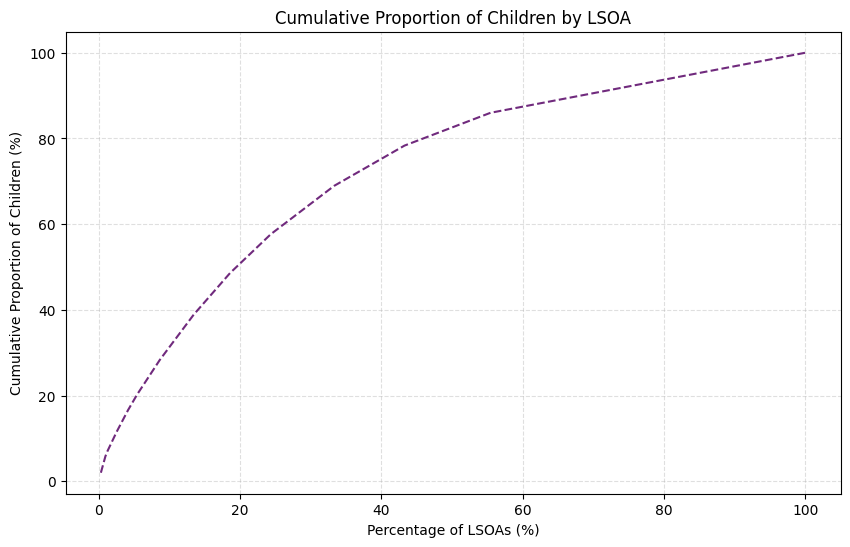

In [32]:
# Number of children
total_children = children_per_lsoa['children_count'].sum()

# Sort by children_count (descending):
children_per_lsoa_sorted = children_per_lsoa.sort_values(by='children_count', ascending=False)

# Calculate the cumulative sum and proportion:
children_per_lsoa_sorted['cumulative_children'] = children_per_lsoa_sorted['children_count'].cumsum()
children_per_lsoa_sorted['cumulative_percent'] = (
    100.0 * children_per_lsoa_sorted['cumulative_children'] / total_children
)

# Create an x-axis representing the percentage of LSOAs.
# Each point's x-value is (index position / total LSOAs) * 100
num_lsoas = len(children_per_lsoa_sorted)
x_percent = [(i + 1) / num_lsoas * 100 for i in range(num_lsoas)]

# Plot cumulative proportion vs. number of LSOAs:
plt.figure(figsize=(10, 6))
plt.plot(
    x_percent,
    children_per_lsoa_sorted['cumulative_percent'],
    linestyle='--',
    color=color
)
plt.title('Cumulative Proportion of Children by LSOA')
plt.xlabel('Percentage of LSOAs (%)')
plt.ylabel('Cumulative Proportion of Children (%)')
plt.grid(True, linestyle='--', alpha=.4)
plt.savefig("../figs/children_proportion_per_LSOAproportion.png", dpi=300)
plt.show()

#### LAC Rate vs. IMD Decile by LSOA -  Is there a relationship btw rate of LAC and the IMD rank of the LSOA = are more LAC in deprived areas?

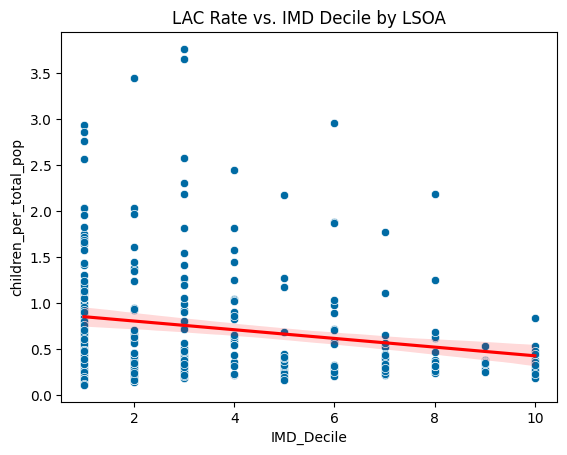

Pearson Correlation: -0.207 (p-value: 2.467e-04)
Spearman Correlation: -0.184 (p-value: 1.200e-03)

Linear Regression Results:
Slope: -0.047227
Intercept: 0.902
R-squared: 0.043
P-value: 2.467e-04


In [33]:
sns.scatterplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop'
)

# Add a trendline
sns.regplot(
    data=children_population,
    x='IMD_Decile',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IMD Decile by LSOA')
plt.savefig("../figs/LAC_Rate_vs.IMD_Decile.png", dpi=300)
plt.show()


# Determine the relationship between IMD Decile and Proportion of LAC 


# Drop rows with NaN
valid = (
    children_population['IMD_Decile'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IMD_Decile'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

The downward slope suggest that there's a negative correlation between the rate of LAC per population and the IMD rank.<br>
It appears to be a relationship between deprivation and rate of LAC, where more deprived areas tend to have more number of LAC & higher rates of LAC<br>
Small p-values indicates evidence of association between the variables - not by chance. <br>
Weak correlation coeeficients means that IMD rank is not a strong predictor of the proportion of children.<br>
Negative slope - Less deprived areas have less proportion of LAC<br>
R-squared value implies that only 6% of the variation in LAC rate is explained by the IMD Decile. Hence, other factors plays important roles in explainging the LAC rate per population.

### LAC Rate and IDCScore -  child-specific deprivation measure

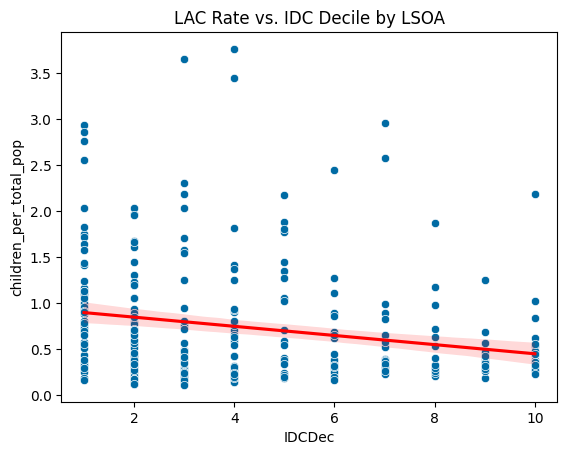

Pearson Correlation: -0.224 (p-value: 7.432e-05)
Spearman Correlation: -0.243 (p-value: 1.668e-05)

Linear Regression Results:
Slope: -0.049790
Intercept: 0.951
R-squared: 0.050
P-value: 7.432e-05


In [34]:
sns.scatterplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop'
)

# Add a trendline
sns.regplot(
    data=clean_data,
    x='IDCDec',
    y='children_per_total_pop',
    scatter=False,
    color='red'
)
plt.title('LAC Rate vs. IDC Decile by LSOA')
plt.show()

# Determine the relationship between IDCDec and Proportion of LAC 

# Drop rows with NaN
valid = (
    children_population['IDCDec'].notna() &
    children_population['children_per_total_pop'].notna()
)
clean_data = children_population[valid]

# Pearson Correlation
correlation, p_value = stats.pearsonr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Spearman Correlation
spearman_corr, spearman_p = stats.spearmanr(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Linear Regression
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(clean_data['IDCDec'], clean_data['children_per_total_pop'])

# Print results
print(f"Pearson Correlation: {correlation:.3f} (p-value: {p_value:.3e})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3e})")
print("\nLinear Regression Results:")
print(f"Slope: {slope:.6f}")
print(f"Intercept: {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value_reg:.3e}")

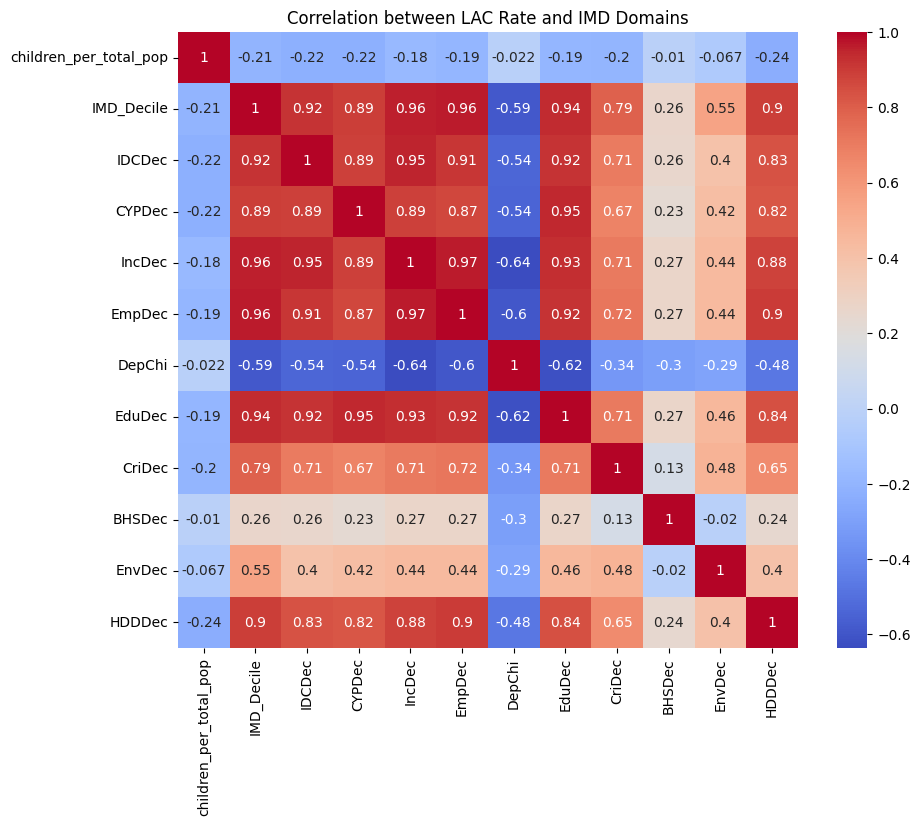

In [35]:
# Correlation Matric for IMD variables and lac rate per lsoa population
corr_matrix = clean_data[[
    'children_per_total_pop', 'IMD_Decile',
    'IDCDec', 'CYPDec', 'IncDec', 'EmpDec', 'DepChi',
    'EduDec', 'CriDec', 'BHSDec', 'EnvDec', 'HDDDec'
]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between LAC Rate and IMD Domains')
plt.show()

### Correlation between LAC Population Rate and IMDs

In [37]:
import statsmodels.formula.api as smf

# 1. Define the formula for ordinary least squares (OLS) regression:
formula = "children_per_total_pop ~ DepChi + IncDec + EmpDec + EduDec + EnvDec + IDCDec + CriDec + HDDDec + CYPDec + BHSDec"

# 2. Fit the model
model = smf.ols(formula, data=children_population).fit()

# 3. Print a summary of the regression results
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     children_per_total_pop   R-squared:                       0.111
Model:                                OLS   Adj. R-squared:                  0.081
Method:                     Least Squares   F-statistic:                     3.708
Date:                    Thu, 06 Feb 2025   Prob (F-statistic):           0.000106
Time:                            14:32:28   Log-Likelihood:                -283.43
No. Observations:                     308   AIC:                             588.9
Df Residuals:                         297   BIC:                             629.9
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

# Duration Spent in Intervention

#### Average Duration in Intervention per LSOA - Are there clusters of LSOA where LAC are spending more time in intervention?

In [39]:
cic_english_lsoa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1160 entries, 1 to 1915
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   person_id     1160 non-null   object             
 1   PCArea        1160 non-null   object             
 2   StartDate     1160 non-null   dbdate             
 3   EndDate       581 non-null    dbdate             
 4   EthnicOrigin  1160 non-null   object             
 5   DateOfBirth   1160 non-null   datetime64[us, UTC]
 6   LSOA          1160 non-null   object             
 7   Category      643 non-null    object             
 8   lsoa_prefix   1160 non-null   object             
dtypes: datetime64[us, UTC](1), dbdate(2), object(6)
memory usage: 90.6+ KB


In [43]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   lsoa21cd                     992 non-null    object             
 1   name                         992 non-null    object             
 2   geometry                     992 non-null    geometry           
 3   person_id                    907 non-null    object             
 4   PCArea                       907 non-null    object             
 5   StartDate                    907 non-null    datetime64[ns, UTC]
 6   EndDate                      474 non-null    datetime64[ns, UTC]
 7   EthnicOrigin                 907 non-null    object             
 8   DateOfBirth                  907 non-null    datetime64[ns, UTC]
 9   Category                     491 non-null    object             
 10  lsoa_prefix                  907 non-null 

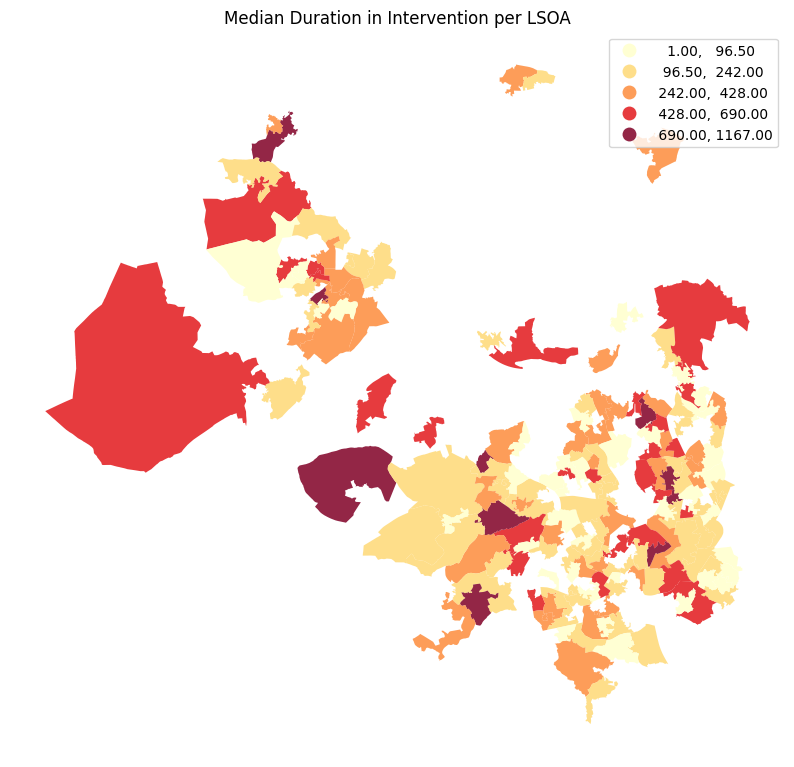

In [65]:
# Create new df for durations
durations_df = merged_data[['lsoa21cd', 'geometry', 'num_of_days_in_intervention']]

# Group by LSOA and calculate mean & median
durations_agg = durations_df.groupby('lsoa21cd', as_index=False).agg(
    mean_duration=('num_of_days_in_intervention', np.nanmean),
    median_duration=('num_of_days_in_intervention', np.nanmedian),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

# Plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) 

durations_agg.plot(
    ax=ax,                  
    column='median_duration',
    scheme='NaturalBreaks',     
    cmap='YlOrRd',
    alpha=0.85,
    legend=True,            
)

# Remove axis for better visualization
ax.set_axis_off()

# Add a title
ax.set_title("Median Duration in Intervention per LSOA")

# Show the plot
plt.show()

In [70]:
durations_agg.describe()

,mean_duration,median_duration
count,312.000000,312.000000
mean,166.024943,153.405449
std,217.409802,218.466833
min,0.000000,0.000000
25%,0.000000,0.000000
50%,56.000000,24.000000
75%,275.178571,235.500000
max,975.000000,1167.000000


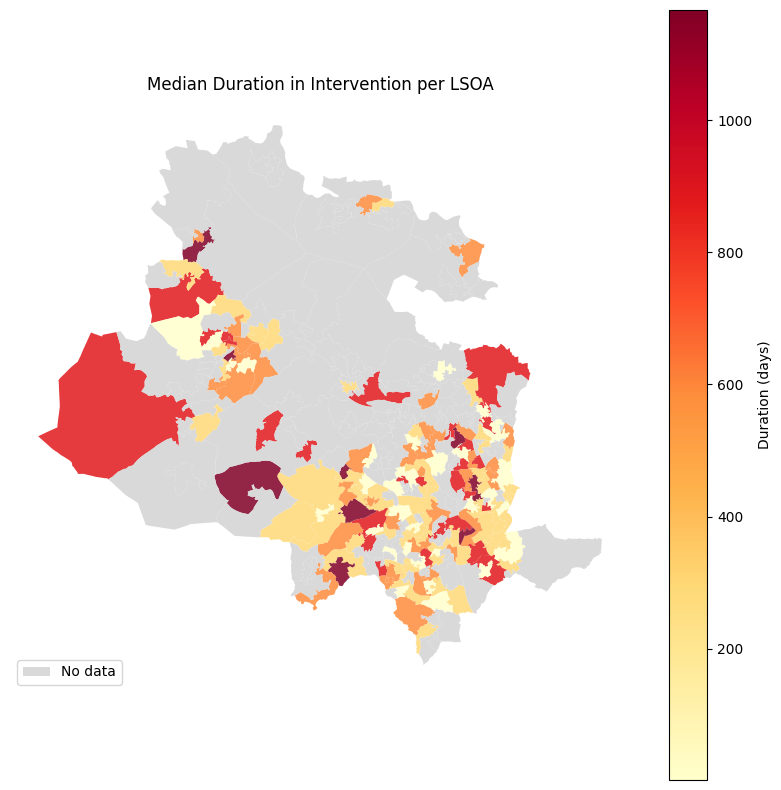

In [84]:
# Your aggregation code remains the same
durations_agg = durations_df.groupby('lsoa21cd', as_index=False).agg(
    mean_duration=('num_of_days_in_intervention', np.nanmean),
    median_duration=('num_of_days_in_intervention', np.nanmedian),
    geometry=('geometry', 'first')
).pipe(gpd.GeoDataFrame)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Plot with missing values handled by GeoDataFrame
plot = durations_agg.plot(
    ax=ax,
    column='median_duration',
    scheme='NaturalBreaks',
    cmap='YlOrRd',
    alpha=0.85,
    legend=False,  # Turn off automatic legend
    missing_kwds={'color': 'lightgrey'}  # Keep the grey color for missing values
)

# Create color bar manually
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

vmin = durations_agg['median_duration'].min()
vmax = durations_agg['median_duration'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrRd')
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Duration (days)')

# Add custom legend for missing values
legend_elements = [Patch(facecolor='lightgrey', alpha=0.85, label='No data')]
ax.legend(handles=legend_elements, loc='lower left')

ax.set_axis_off()
ax.set_title("Median Duration in Intervention per LSOA")

plt.show()

In [77]:
durations_agg['median_duration'].describe()

count     312.000000
mean      153.405449
std       218.466833
min         0.000000
25%         0.000000
50%        24.000000
75%       235.500000
max      1167.000000
Name: median_duration, dtype: float64

In [ ]:
# Compare the Average Duration in Intervention with IMD Decile

# First ensure we have IMD data merged
lsoa_durations = lsoa_durations.merge(
    imd[['lsoa11cd', 'IMD_Decile']],
    left_on ='lsoa21cd',
    right_on='lsoa11cd',
    how='left'
).drop(columns='lsoa11cd')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

# Plot Duration Map
lsoa_durations.plot(
    column='mean_duration',
    cmap='RdYlGn_r',
    edgecolor='lightgrey',
    scheme='quantiles',
    legend=True,
    legend_kwds={'title': 'Duration (days)'},
    ax=ax1
)
ax1.set_title("Average Intervention Duration")
ax1.set_axis_off()

# Plot IMD Decile Map
lsoa_durations.plot(
    column='IMD_Decile',
    cmap='RdPu',
    edgecolor='lightgrey',
    scheme='quantiles',
    classification_kwds={'bins': np.arange(1, 11)},
    legend=True,
    legend_kwds={'title': 'IMD Decile (1=most deprived)'},
    ax=ax2
)
ax2.set_title("Index of Multiple Deprivation")
ax2.set_axis_off()

# Add basemap context to both
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=lsoa_durations.crs.to_string())
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, crs=lsoa_durations.crs.to_string())

plt.tight_layout()
# plt.savefig('duration_imd_comparison.png', dpi=300)

## Global Spatial Autocorrelation - Moran's I
Global Moran's I to test for overall spatial autocorrelation in intervention duration

In [ ]:


# Create weights matrix
w = Queen.from_dataframe(lsoa_durations)
w.transform = 'r'  # Row-standardize weights

# Calculate Moran's I
moran = Moran(lsoa_durations['mean_duration'], w)

# Calculate spatial lag
spatial_lag = w.sparse.toarray() @ lsoa_durations['mean_duration']

# Create Moran Scatterplot
plt.figure(figsize=(6, 6))

# Plot points
plt.scatter(lsoa_durations['mean_duration'],
           spatial_lag,
           alpha=0.6)

# Add trend line
z = np.polyfit(lsoa_durations['mean_duration'], spatial_lag, 1)
p = np.poly1d(z)
plt.plot(lsoa_durations['mean_duration'],
         p(lsoa_durations['mean_duration']),
         "r--",
         alpha=0.8)

# Add vertical and horizontal lines at means
plt.axvline(lsoa_durations['mean_duration'].mean(),
           color='gray',
           linestyle='--',
           alpha=0.5)
plt.axhline(spatial_lag.mean(),
           color='gray',
           linestyle='--',
           alpha=0.5)

# Labels and title
plt.xlabel('Intervention Duration')
plt.ylabel('Spatial Lag of Intervention Duration')
plt.title(f"Moran Scatterplot (I={moran.I:.3f})")

# Add quadrant labels
plt.text(0.98, 0.98, 'HH',
         transform=plt.gca().transAxes,
         ha='right',
         va='top')
plt.text(0.02, 0.98, 'LH',
         transform=plt.gca().transAxes,
         ha='left',
         va='top')
plt.text(0.98, 0.02, 'HL',
         transform=plt.gca().transAxes,
         ha='right',
         va='bottom')
plt.text(0.02, 0.02, 'LL',
         transform=plt.gca().transAxes,
         ha='left',
         va='bottom')

plt.tight_layout()
plt.show()

# Print Moran's I statistics
print(f"Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")

________________
The very close to 0 Moran's I value indicates no significant spatial autocorrelation. This means spatial distirbution of intervention durations is random.

# Bivariate Moran's I - Spatial correlation between average duration and IMD Decile

In [ ]:
from esda.moran import Moran_BV

# Calculate bivariate Moran's I
bv_moran = Moran_BV(lsoa_durations['mean_duration'],
                    lsoa_durations['IMD_Decile'],
                    w)
print(f"Bivariate Moran's I: {bv_moran.I}")
print(f"P-value: {bv_moran.p_sim}")

## Ethnic Groups per LSOA

In [ ]:
# Get the top 10 ethnicities by population count
ethnicity_counts = merged_data.groupby('EthnicOrigin').size().sort_values(ascending=False)
top_10_ethnicities = ethnicity_counts.head(10).index.tolist()

# Group by LSOA and get ethnic counts for top 10 only
ethnicity_counts = merged_data[merged_data['EthnicOrigin'].isin(top_10_ethnicities)]\
    .groupby(['lsoa21cd', 'EthnicOrigin']).size().reset_index(name='count')
ethnicity_pivot = ethnicity_counts.pivot(index='lsoa21cd',
                                       columns='EthnicOrigin',
                                       values='count').fillna(0)

# Calculate percentages
ethnicity_percentages = ethnicity_pivot.div(ethnicity_pivot.sum(axis=1), axis=0) * 100

# Merge with your children_population geodataframe
Children_population_with_ethnicity = children_population.merge(ethnicity_percentages,
                                         left_on='lsoa21cd',
                                         right_index=True,
                                         how='left')

# Plot
fig, axes = plt.subplots(5, 2, figsize=(16, 20))  # 5 rows, 2 columns for top 10
axes = axes.flatten()

for idx, ethnic_group in enumerate(top_10_ethnicities):
    Children_population_with_ethnicity.plot(column=ethnic_group,
                       ax=axes[idx],
                       legend=True,
                       legend_kwds={'label': f'{ethnic_group} %'},
                       cmap='YlOrRd')  
    axes[idx].set_title(f'{ethnic_group}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate total population for each LSOA (using ALL ethnic groups)
lsoa_total_pop = merged_data.groupby('lsoa21cd').size()

# Get counts for each ethnicity in each LSOA
lsoa_ethnic_counts = merged_data.groupby(['lsoa21cd', 'EthnicOrigin']).size().reset_index(name='count')

# Calculate percentages using total population
lsoa_ethnic_counts['percentage'] = lsoa_ethnic_counts.apply(
    lambda x: (x['count'] / lsoa_total_pop[x['lsoa21cd']]) * 100, axis=1
)

# Find top 10 ethnicities by total population
top_10_ethnicities = merged_data['EthnicOrigin'].value_counts().head(10).index

# Filter for top 10 but keep percentages based on total population
top_10_ethnic_percentages = lsoa_ethnic_counts[
    lsoa_ethnic_counts['EthnicOrigin'].isin(top_10_ethnicities)
].pivot(index='lsoa21cd', columns='EthnicOrigin', values='percentage')

# Merge with your cluster data
final_analysis = children_population.merge(top_10_ethnic_percentages,
                                         left_on='lsoa21cd',
                                         right_index=True,
                                         how='left')

# Create the plot
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.flatten()

for idx, ethnic_group in enumerate(top_10_ethnicities):
    final_analysis.plot(column=ethnic_group,
                       ax=axes[idx],
                       legend=True,
                       legend_kwds={'label': f'Percentage'},
                       cmap='YlOrRd')
    axes[idx].set_title(f'{ethnic_group}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate category counts per LSOA
category_counts = merged_data.groupby(['lsoa21cd', 'Category']).size().reset_index(name='count')

# Find dominant category for each LSOA
dominant_categories = category_counts.loc[category_counts.groupby('lsoa21cd')['count'].idxmax()]

# Create unique geometry dataset
lsoa_geo = merged_data[['lsoa21cd', 'geometry']].drop_duplicates()

# Merge geometry with dominant categories
final_gdf = lsoa_geo.merge(dominant_categories, on='lsoa21cd')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
final_gdf.plot(column='Category',
               categorical=True,
               legend=True,
               ax=ax,
               legend_kwds={'bbox_to_anchor': (1.3, 1),
                            'title': 'Categories'},
               cmap='tab20')

ax.set_title('Dominant Categories by LSOA', fontsize=16)
ax.set_axis_off()